# 1次元の拡散モデルによる平均の推測

Train Data: [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004 -0.46341769 -0.46572975
  0.24196227 -1.91328024 -1.72491783 -0.56228753 -1.01283112  0.31424733
 -0.90802408 -1.4123037   1.46564877 -0.2257763   0.0675282  -1.42474819
 -0.54438272  0.11092259 -1.15099358  0.37569802 -0.60063869 -0.29169375
 -0.60170661  1.85227818 -0.01349722 -1.05771093  0.82254491 -1.22084365
  0.2088636  -1.95967012 -1.32818605  0.19686124  0.73846658  0.17136828
 -0.11564828 -0.3011037  -1.47852199 -0.71984421 -0.46063877  1.05712223
  0.34361829 -1.76304016]
Epoch 1, Loss: 0.9954594671726227
Epoch 2, Loss: 1.2839451789855958
Epoch 3, Loss: 1.2522747993469239
Epoch 4, Loss: 0.8122538208961487
Epoch 5, Loss: 0.7903232157230378
Epoch 6, Loss: 0.5990409016609192
Epoch 7, Loss: 0.7173824489116669
Epoch 8, Loss: 0.7732816159725189
Epoch 9, Loss: 0.7223628401756287
Epoch 10, Loss: 0.5519383192062378


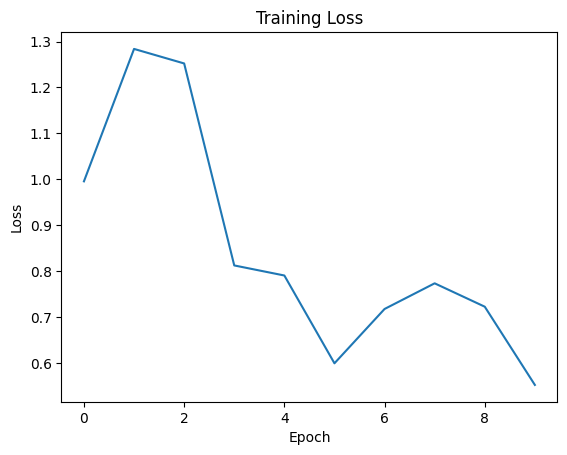

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

# ハイパーパラメータ
num_timesteps = 1000 # 拡散ステップ数
epochs = 10          # 学習エポック数
lr = 1e-3            # 学習率
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Pytorchの組み込み演算により効率的に計算
# 高次元データ用のtorch.arrangeやtorch.expを活用してコードを簡潔に

# 時間埋め込み（正弦波位置エンコーディング）
def pos_encoding(timesteps, output_dim, device='cpu'):
    position = timesteps.view(-1, 1).float()  # 必要に応じて型変換
    div_term = torch.exp(torch.arange(0, output_dim, 2, device=device, dtype=torch.float32) * 
                         (-np.log(10000.0) / output_dim))
    sinusoid = torch.cat([torch.sin(position * div_term), torch.cos(position * div_term)], dim=1)
    return sinusoid

# Dropoutの導入: 過学習を防ぐために、各隠れ層にnn.Dropoutを追加。
# Batch Normalizationの導入: 学習を安定させるためにnn.BatchNorm1dを適用。
# 活性化関数の選択: F.reluの代わりにnn.LeakyReLUやnn.ELUを試すことで、勾配消失問題に対応。

# 拡散モデル
class DiffusionModel(nn.Module):
    def __init__(self, time_embed_dim=16):
        super(DiffusionModel, self).__init__()
        self.time_embed_dim = time_embed_dim  # time_embed_dimをインスタンス変数として初期化
        self.fc1 = nn.Linear(1 + time_embed_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x, t):
        # 時間埋め込み
        t_embed = pos_encoding(t, self.time_embed_dim, x.device)
        x_t = torch.cat([x, t_embed], dim=1)  # 時間情報と入力データを結合
        x_t = F.relu(self.fc1(x_t))
        x_t = F.relu(self.fc2(x_t))
        return self.fc3(x_t)

# 拡散プロセス
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        t_idx = t - 1 # alphas[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)  # (N, 1)
        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()
        
        t_idx = t - 1 # alphas[0] is for t=1
        alpha = self.alphas[t_idx].view(-1, 1)
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)
        model.eval()
        with torch.no_grad():
            eps = model(x, t)

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - (1 - alpha) / torch.sqrt(1 - alpha_bar) * eps) / torch.sqrt(alpha)

        return mu

# モデルとオプティマイザ
time_embed_dim = 16
model = DiffusionModel(time_embed_dim=time_embed_dim).to(device)
optimizer = Adam(model.parameters(), lr=lr)
diffuser = Diffuser(num_timesteps=num_timesteps, device=device)

# シード値の固定
np.random.seed(42)

# 学習データ(ガウスノイズ)
data = np.random.randn(50)  # shape: (50,)
# scaler = StandardScaler()
# data = scaler.fit_transform(data.reshape(-1, 1)).flatten()
print("Train Data:", data)
train_data = torch.tensor(data, dtype=torch.float32).view(-1, 1).to(device)  # shape: (10, 1)

# データローダー作成
batch_size = 10
dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 学習ループ
losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    for batch in dataloader:
        optimizer.zero_grad()
        x = batch.to(device)
        t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise_pred, noise)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
    avg_loss = loss_sum / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

# 学習曲線のプロット
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [8]:
# サンプリング
model.eval()
with torch.no_grad():
    n = 50 # 1データセットあたりのサンプル数
    B = 1000 # データセットの数
    new_sample_list = []
    for _ in range(B):
        torch.manual_seed(np.random.randint(0, 10000))
        samples = torch.randn((n, 1), device=device)  # ランダムなノイズから開始
        for t in range(num_timesteps, 0, -1):
            t_tensor = torch.tensor([t] * len(samples), device=device)
            samples = diffuser.denoise(model, samples, t_tensor)
        samples = samples.view(n).cpu().numpy()
        # samplesを保存する
        new_sample_list.append(samples)
new_sample_list = np.array(new_sample_list)
print("new_sample_list:", new_sample_list)
print('Samples Shape:', new_sample_list.shape)

new_sample_list: [[ 5.8672333  -0.6297929   0.72311604 ...  0.06708281 -0.02998939
   3.383625  ]
 [-0.05650859  0.15902974  0.23440482 ... -0.5583298   0.40327197
   9.355315  ]
 [ 1.4147953   2.645728   -0.08193155 ... -0.8004043   0.8964942
  -0.3530574 ]
 ...
 [ 9.452745   -1.2782558   3.4878755  ... -1.091581    0.7320315
  -1.744784  ]
 [ 0.67890227  0.60155165  1.6185266  ... -2.7793672   3.836644
   1.1636262 ]
 [ 0.49757698 -1.7178276  -0.24435307 ... -0.19680388  8.221514
   0.74809164]]
Samples Shape: (1000, 50)


In [13]:
new_sample_list_mean = np.mean(new_sample_list, axis=1)
print("new_sample_list_mean:", new_sample_list_mean)
print('Samples Mean Shape:', new_sample_list_mean.shape)

new_sample_list_mean: [-2.83953846e-01  6.63796067e-02  5.53846657e-01  3.89382124e-01
  8.18527937e-01 -1.80313095e-01  7.61538818e-02  2.45229721e-01
 -5.49205482e-01  2.88606435e-01  7.21097410e-01 -1.86953172e-02
  3.24788064e-01 -1.20401643e-01  1.21297145e+00  3.64927948e-01
  1.56278145e-02  2.60561198e-01  1.17094144e-02 -2.08455175e-01
 -6.19733632e-01  3.68834943e-01 -9.24556851e-02  6.63992688e-02
 -3.51352543e-01 -1.66598380e-01  2.55355150e-01  1.04071498e+00
  2.64117479e-01  2.69293159e-01  8.86768997e-02 -2.95327008e-01
  3.28371555e-01  1.53210461e-01  3.30789804e-01  2.89056391e-01
 -1.16107510e-02  1.58445477e+00  5.66753626e-01  3.91556993e-02
 -3.76498371e-01  6.44560575e-01  1.43153691e+00  8.31193924e-01
  7.12729037e-01  5.67116737e-01 -2.25899443e-01 -6.03619926e-02
  1.38376400e-01  3.69321138e-01  2.27780700e-01  1.51243240e-01
  5.57028174e-01  3.17397416e-01  6.16771221e-01  1.46885800e+00
 -2.09797993e-01 -2.30200425e-01  1.04497588e+00  1.02219713e+00
  4

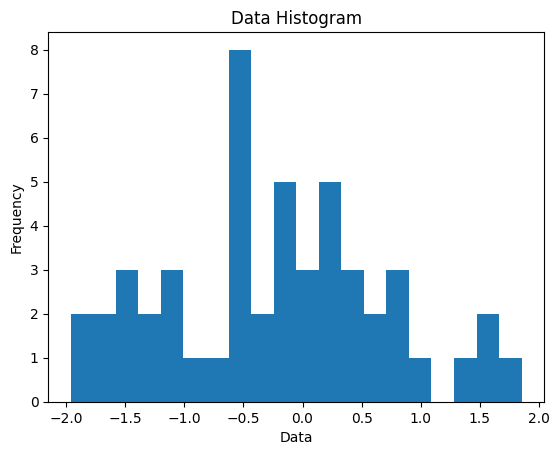

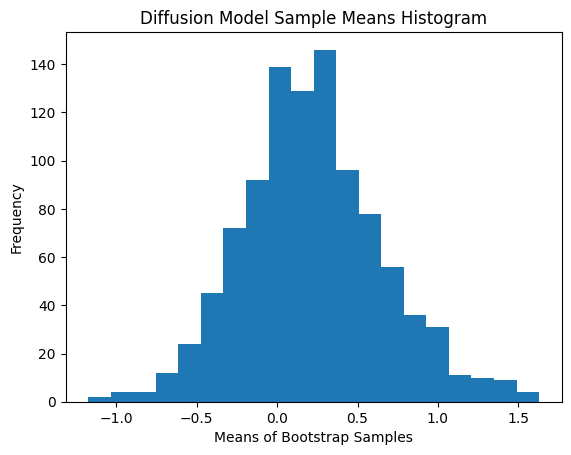

In [14]:
# 元データのヒストグラム
plt.hist(data, bins=20)
plt.xlabel('Data')
plt.ylabel('Frequency')
plt.title('Data Histogram')
plt.show()

# sample_listのヒストグラム
plt.hist(new_sample_list_mean, bins=20)
plt.xlabel('Means of Bootstrap Samples')
plt.ylabel('Frequency')
plt.title('Diffusion Model Sample Means Histogram')
plt.show()


In [16]:
import statistics
# もとデータの平均
print("Original_Data.mean", statistics.mean(data))
# もとデータの分散
print("Original_Data.pvariance", statistics.pvariance(data))
# 標本平均
print("sampled_data.mean", statistics.mean(new_sample_list_mean))
# 標本分散  
print("sampled_data.pvariance", statistics.pvariance(new_sample_list_mean))

Original_Data.mean -0.22547390525614008
Original_Data.pvariance 0.8543026463778314
sampled_data.mean 0.22012477
sampled_data.pvariance 0.1910283


In [5]:
print('data', data)
# もとデータの平均
print("Original Data", statistics.mean(data))
# もとデータの分散
print("Original Data", statistics.pvariance(data))

data [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004 -0.46341769 -0.46572975
  0.24196227 -1.91328024 -1.72491783 -0.56228753 -1.01283112  0.31424733
 -0.90802408 -1.4123037   1.46564877 -0.2257763   0.0675282  -1.42474819
 -0.54438272  0.11092259 -1.15099358  0.37569802 -0.60063869 -0.29169375
 -0.60170661  1.85227818 -0.01349722 -1.05771093  0.82254491 -1.22084365
  0.2088636  -1.95967012 -1.32818605  0.19686124  0.73846658  0.17136828
 -0.11564828 -0.3011037  -1.47852199 -0.71984421 -0.46063877  1.05712223
  0.34361829 -1.76304016]
Original Data -0.22547390525614008
Original Data 0.8543026463778314
